### Mario Eduardo Tabarini Andretta
### 22000349
## Laboratorio No. 3


In [103]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import category_encoders as ce
from sklearn.neighbors import KernelDensity
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, Binarizer

from sklearn.linear_model import LinearRegression

from feature_engine.imputation import AddMissingIndicator, MeanMedianImputer, CategoricalImputer
from feature_engine.encoding import RareLabelEncoder, OrdinalEncoder
from feature_engine.transformation import LogTransformer
from feature_engine.selection import DropFeatures
from feature_engine.wrappers import SklearnTransformerWrapper

import myPreprocessors as mypp


from IPython.display import display, HTML

import joblib


In [8]:
data = pd.read_csv('train.csv') #Se importa acrhivo .CSV
data.shape

(14447, 11)

In [9]:
data.head() #Se anailza estructura de dataset

,id,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,9744,-121.65,36.77,15,2191,358.0,1150,330,4.7969,227500.0,<1H OCEAN
1,13893,-116.27,34.13,37,452,109.0,184,59,3.7292,65800.0,INLAND
2,18277,-122.07,37.34,35,1172,184.0,512,175,7.3561,500001.0,<1H OCEAN
3,16176,-122.39,37.74,52,126,24.0,37,27,10.2264,225000.0,NEAR BAY
4,8843,-118.38,34.09,28,4001,1352.0,1799,1220,2.5784,272900.0,<1H OCEAN


#### 1. Determine qué columnas poseen faltantes (NA o nulos)

In [10]:
cols_con_na = [col for col in data.columns if (data[col].isnull().mean() > 0)] #Se crea un dataset con las columnas que cuentan con valores nulos
cols_con_na

['total_bedrooms']

#### 2. Determine la proporción de faltantes para cada columna con faltantes, muestre una gráfica de barras.

In [11]:
prop_nan_per_col = data[cols_con_na].isnull().mean() #Se determina la proporción de nulos para cada columna del dataset que tiene nulos
prop_nan_per_col

total_bedrooms    0.009483
dtype: float64

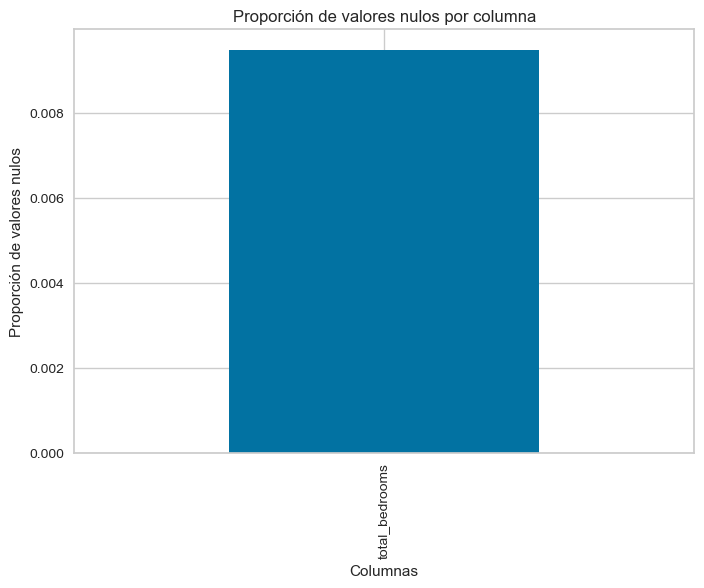

In [130]:
prop_nan_per_col.plot(kind='bar') #Se crea gráfica de barras de proporción de nulos
plt.xlabel('Columnas')
plt.ylabel('Proporción de valores nulos')
plt.title('Proporción de valores nulos por columna')

# Mostrar la gráfica
plt.show()


#### 4. Si la variable es numérica realice un análisis de cual sería el mejor método para realizar la imputación de datos, debe mostrar un bloque de código donde se muestre cada imputación y su análisis. Recuerde que puede ser: a. Eliminar los faltantes, b. Imputación de media o mediana, c. Valores arbitrarios (extremo derecho y extremo izquierdo), d. Generación de números aleatorios en base a la distribución (no visto en clase).

In [13]:
data[cols_con_na].dtypes

total_bedrooms    float64
dtype: object

In [14]:
cols_rescatables = [col for col in data.columns if (data[col].isnull().mean() <= 0.05)] #Se crea un dataset que incluya las columnas para las que es posible realizar imputación y no afecte a más del 5%.
cols_rescatables

['id',
 'longitude',
 'latitude',
 'housing_median_age',
 'total_rooms',
 'total_bedrooms',
 'population',
 'households',
 'median_income',
 'median_house_value',
 'ocean_proximity']

##### La variable con faltantes es numérica (tipo float64), por lo que se procederá a realizar cada imputación y evaluar el método ideal.
#
#
#
##### a. Eliminar columnas con faltantes

In [15]:
newData = data[cols_rescatables].dropna() # Se eliminan los nulos en las columnas, dejando la misma cantidad de columnas, pero 137 filas menos.

data.shape, newData.shape

((14447, 11), (14310, 11))

##### b. Imputación de media y mediana

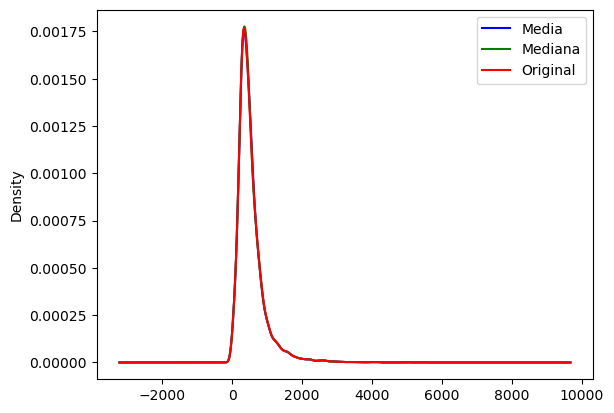

In [16]:
newData=data

media = newData['total_bedrooms'].mean() #Se determina la media de la columna total_bedrooms
newData['total_bedrooms_mean'] = np.round(newData['total_bedrooms'].fillna(media)) #Se imputa la media en los faltantes


mediana = newData['total_bedrooms'].median() #Se determina la mediama de la columna total_bedrooms
newData['total_bedrooms_median'] = np.round(newData['total_bedrooms'].fillna(mediana)) #Se imputa la mediana en los faltantes

newData.shape

fig = plt.figure()
ax = fig.add_subplot(111)


#Se procede a comparar las gráficas de densidad de las tres columnas (total bedrooms con media imputada, total bedrooms cno mediana imputada y total bedooms original)

newData['total_bedrooms_mean'].plot.density(color='blue', label='Media')
newData['total_bedrooms_median'].plot.density(color='green', label='Mediana')
newData['total_bedrooms'].plot.density(color='red', label='Original')
ax.legend()

##### c. Imputación de valores arbitrarios

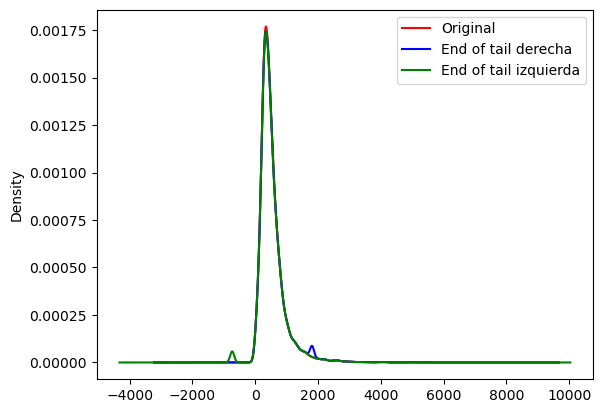

In [17]:
newData=data

media = newData['total_bedrooms'].mean() # Se calcula media de columna total bedooms
desviacion=newData['total_bedrooms'].std() # Se calcula desviación estándar de columna total bedrooms
desviacion

imp_derecha=media+3*desviacion #Se alcula la imputación a partir de los datos de la cola derecha
imp_derecha

imp_izquierda=media-3*desviacion  #Se alcula la imputación a partir de los datos de la cola izquierda
imp_izquierda

newData['total_bedrooms_imp_derecha'] = np.round(newData['total_bedrooms'].fillna(imp_derecha)) # Se imputan datos de cola derecha
newData['total_bedrooms_imp_izquierda'] = np.round(newData['total_bedrooms'].fillna(imp_izquierda)) # Se imputan datos de cola izquierda


# Se reailza gráfica para comparar las tres imputaciones
fig = plt.figure()
ax = fig.add_subplot(111)
newData['total_bedrooms'].plot.density(color='red', label='Original')
newData['total_bedrooms_imp_derecha'].plot.density(color='blue', label='End of tail derecha')
newData['total_bedrooms_imp_izquierda'].plot.density(color='green', label='End of tail izquierda')
ax.legend()

#### d. Generación de números aleatorios con base en la distribución

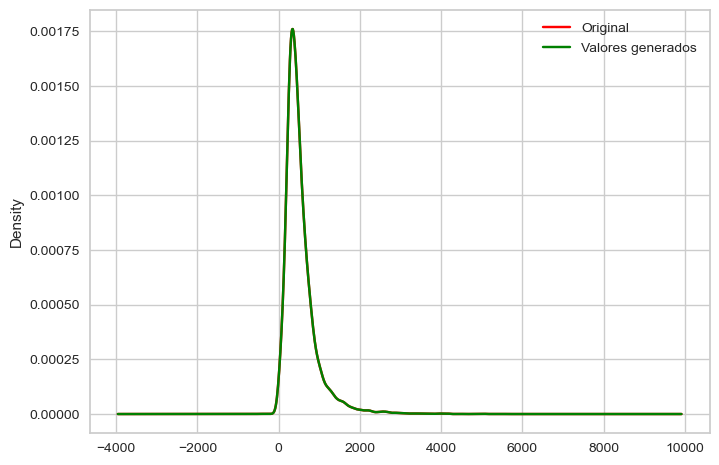

In [136]:
newData=data
total_bedrooms_sin_na = data['total_bedrooms'].dropna() #Se eliminan na de columna total bedrooms y se crea columna con base en dichos valores
    
media = total_bedrooms_sin_na.mean()
desviacion_estandar = total_bedrooms_sin_na.std()
    
valores_generados = np.random.normal(media, desviacion_estandar, data['total_bedrooms'].isnull().sum()) #Se genran valores arbitrarios basados en media y desviación estándar
    
data.loc[data['total_bedrooms'].isnull(), 'total_bedrooms'] = valores_generados #Se llena columna de data total_bedrooms con los datos generados


#Se genera gráfica que compara la columna con valores originales y con datos imputados.
fig = plt.figure()
ax = fig.add_subplot(111)
newData['total_bedrooms'].plot.density(color='red', label='Original')
data['total_bedrooms'].plot.density(color='green', label='Valores generados')
ax.legend()


##### Conclusión: Los métodos ideales para tratar los faltantes son mediante la imputación de media, mediana o de números generados con base en la distribución. Para el ejercicio en cuestión, se procederá a emplear la imputación de medias.

#### 4. Si la variable es categórica, realice una imputación que considere necesaria.
#
#
##### R/ Como se determinó en los incisos anteriores, la única variable con faltantes es de tipo numérico, por lo que no se hace necesaria una imputación categórica.  

#### 5. Realice la codificación de variables categóricas, determine cual es le mejor enfoque para cada caso, recuerde que puede realizar los siguientes enfoques: a. One Hote Encoding. b. Codificación por Frecuencia. c. Codificación por Densidad.

##### a. One hot encoding

In [19]:
def getCategoryVars(dataset): # Método para determinar qué columas requerirán codificación
     cat_colnames = []
     colnames = dataset.columns
     for col in colnames:
          if(dataset[col].dtype == 'object'):
               cat_colnames.append(col)
     return cat_colnames

cat_cols = getCategoryVars(newData)
cat_cols


['ocean_proximity']

In [20]:
dataset_categories = newData[cat_cols]
dataset_categories.head()

,ocean_proximity
0,<1H OCEAN
1,INLAND
2,<1H OCEAN
3,NEAR BAY
4,<1H OCEAN


In [21]:
dataset_categories['ocean_proximity'].value_counts() #Se determina frecuencia de cada valor en ocean_proximity

<1H OCEAN     6384
INLAND        4577
NEAR OCEAN    1865
NEAR BAY      1619
ISLAND           2
Name: ocean_proximity, dtype: int64

In [22]:
pd.get_dummies(dataset_categories['ocean_proximity']) #Se crean las columnas correspondientes a cada valor de ocean proximity y se asigna 1 para el valor activo en cada fila (valores dummy)

,<1H OCEAN,INLAND,ISLAND,NEAR BAY,NEAR OCEAN
0,1,0,0,0,0
1,0,1,0,0,0
2,1,0,0,0,0
3,0,0,0,1,0
4,1,0,0,0,0
...,...,...,...,...,...
14442,0,0,0,1,0
14443,0,0,0,0,1
14444,0,1,0,0,0
14445,0,1,0,0,0


##### b. Frequency encoding

In [23]:
dataset_categories['ocean_proximity'].value_counts().sort_values(ascending=False) #Se determina frecuencia de cada valor en ocean proximity

<1H OCEAN     6384
INLAND        4577
NEAR OCEAN    1865
NEAR BAY      1619
ISLAND           2
Name: ocean_proximity, dtype: int64

In [24]:
freq_mapper = (dataset_categories['ocean_proximity'].value_counts().sort_values(ascending=False)).to_dict() #Se crea diccionario que codifica los valores de coean proximity con sus frecuencias
freq_mapper

{'<1H OCEAN': 6384,
 'INLAND': 4577,
 'NEAR OCEAN': 1865,
 'NEAR BAY': 1619,
 'ISLAND': 2}

In [25]:
dataset_categories['ocean_proximity_code'] = dataset_categories['ocean_proximity'].map(freq_mapper) #
dataset_categories

C:\Users\Mario T\AppData\Local\Temp\ipykernel_7760\3474333795.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_categories['ocean_proximity_code'] = dataset_categories['ocean_proximity'].map(freq_mapper)


,ocean_proximity,ocean_proximity_code
0,<1H OCEAN,6384
1,INLAND,4577
2,<1H OCEAN,6384
3,NEAR BAY,1619
4,<1H OCEAN,6384
...,...,...
14442,NEAR BAY,1619
14443,NEAR OCEAN,1865
14444,INLAND,4577
14445,INLAND,4577


##### c. Codificación por densidad

In [141]:
densidad = newData['ocean_proximity'].value_counts(normalize=True) #Se determina densidad de cada valor de ocean proximity

kde = KernelDensity().fit(densidad.values.reshape(-1, 1))
densidades_estimadas = np.exp(kde.score_samples(densidad.values.reshape(-1, 1))) #Se crean estimadores de densidad
freq_mapper = dict(zip(densidad.index, densidades_estimadas)) # Se mapea cada valor con su codificacio´n

newData['ocean_proximity_density_code'] = newData['ocean_proximity'].map(freq_mapper) #Se crea una columna con los códigos de densidad para cada valor único

freq_mapper

{'<1H OCEAN': 0.38286975386908056,
 'INLAND': 0.3913699700149974,
 'NEAR OCEAN': 0.39306710928993954,
 'NEAR BAY': 0.3925534753661494,
 'ISLAND': 0.3864639250956019}

#### 6. Para todas las variables resultantes realice Feature Scaling según lo considere más pertinente.

In [39]:
data.describe()

,id,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,total_bedrooms_mean,total_bedrooms_median,total_bedrooms_imp_derecha,total_bedrooms_imp_izquierda,ocean_proximity_code
count,14447.000000,14447.000000,14447.000000,14447.000000,14447.000000,14447.000000,14447.000000,14447.000000,14447.000000,14447.000000,14447.000000,14447.000000,14447.000000,14447.000000,14447.000000
mean,10275.451997,-119.580422,35.642011,28.845435,2635.287534,538.338987,1425.171454,500.116772,3.863949,206873.687824,537.780854,536.785146,549.843151,525.718557,0.387965
std,5957.136373,2.003511,2.135526,12.585221,2215.285809,424.288289,1123.733449,386.181946,1.892919,115263.889710,421.997029,422.119203,439.642553,439.630527,0.004568
min,1.000000,-124.300000,32.540000,1.000000,2.000000,-489.793396,6.000000,1.000000,0.499900,14999.000000,1.000000,1.000000,1.000000,-734.000000,0.382870
25%,5139.500000,-121.805000,33.930000,18.000000,1444.000000,295.000000,786.000000,280.000000,2.567150,119600.000000,297.000000,297.000000,297.000000,292.000000,0.382870
50%,10210.000000,-118.500000,34.260000,29.000000,2121.000000,434.000000,1163.000000,408.000000,3.535000,179700.000000,436.000000,433.000000,436.000000,431.000000,0.391370
75%,15449.000000,-118.020000,37.720000,37.000000,3137.500000,648.000000,1722.000000,604.500000,4.722850,264600.000000,644.000000,644.000000,656.500000,644.000000,0.391370
max,20640.000000,-114.310000,41.950000,52.000000,39320.000000,6445.000000,28566.000000,6082.000000,15.000100,500001.000000,6445.000000,6445.000000,6445.000000,6445.000000,0.393067


In [42]:
def getColumnTypes(dataset): #Función para determinar el tipo de dato en columnas del dataset
     continuas = []
     discretas = []
     categoricas = []
     for col in dataset.columns:
          if((dataset[col].dtype == 'int64') or (dataset[col].dtype == 'float64')):
               if(len(dataset[col].unique()) > 30): 
                    continuas.append(col)
               else:
                    discretas.append(col)
          else:
               categoricas.append(col)

     return continuas, discretas, categoricas

continuas, discretas, categoricas = getColumnTypes(data)

In [44]:
data_temp = data.copy()[continuas] #Se crea un dataset cno datos temporales en el que se encuentran únicamente las variables continuas

In [50]:
scaler = StandardScaler() #Se llama a método de librería para normalizar datoa 
scaler.fit(data_temp)

data_scaled = scaler.transform(data_temp) #Se escala la data temporal
data_scaled = pd.DataFrame(data_scaled, columns=data_temp.columns)

In [51]:
round(data_scaled.describe(), 2) #Se muestra data escalada/normalizada

,id,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,total_bedrooms_mean,total_bedrooms_median,total_bedrooms_imp_derecha,total_bedrooms_imp_izquierda
count,14447.00,14447.00,14447.00,14447.00,14447.00,14447.00,14447.00,14447.00,14447.00,14447.00,14447.00,14447.00,14447.00,14447.00
mean,-0.00,0.00,0.00,0.00,-0.00,-0.00,0.00,-0.00,-0.00,0.00,-0.00,-0.00,-0.00,-0.00
std,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
min,-1.72,-2.36,-1.45,-2.21,-1.19,-2.42,-1.26,-1.29,-1.78,-1.66,-1.27,-1.27,-1.25,-2.87
25%,-0.86,-1.11,-0.80,-0.86,-0.54,-0.57,-0.57,-0.57,-0.69,-0.76,-0.57,-0.57,-0.58,-0.53
50%,-0.01,0.54,-0.65,0.01,-0.23,-0.25,-0.23,-0.24,-0.17,-0.24,-0.24,-0.25,-0.26,-0.22
75%,0.87,0.78,0.97,0.65,0.23,0.26,0.26,0.27,0.45,0.50,0.25,0.25,0.24,0.27
max,1.74,2.63,2.95,1.84,16.56,13.92,24.15,14.45,5.88,2.54,14.00,14.00,13.41,13.46


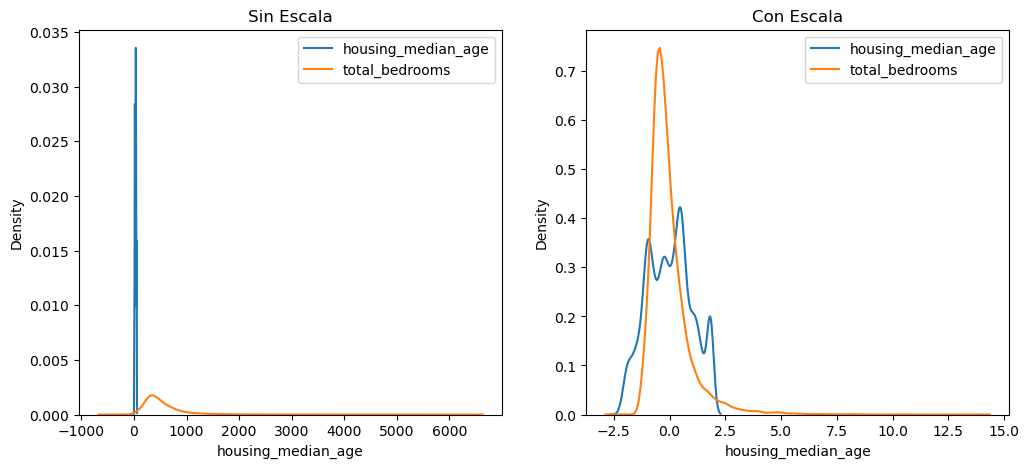

In [54]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 5))


#Gráficas que permiten evaluar el antes y después de la normalización para dos columnas del dataset
ax1.set_title("Sin Escala")
sns.kdeplot(data_temp['housing_median_age'], ax=ax1, label="housing_median_age")
sns.kdeplot(data_temp['total_bedrooms'], ax=ax1, label="total_bedrooms")

ax2.set_title("Con Escala")
sns.kdeplot(data_scaled['housing_median_age'], ax=ax2, label="housing_median_age")
sns.kdeplot(data_scaled['total_bedrooms'], ax=ax2, label="total_bedrooms")

ax1.legend()
ax2.legend()

plt.show()

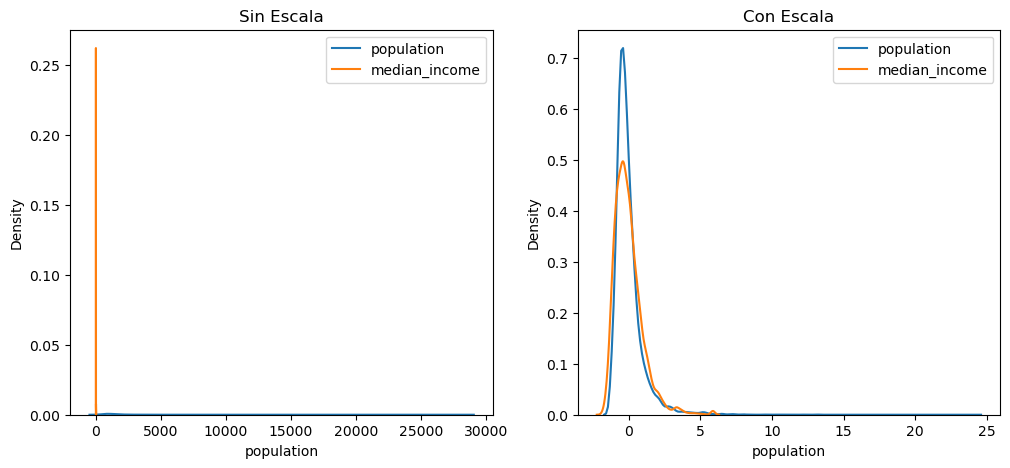

In [55]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 5))


#Gráfica que compara antes y después entre otro conjunto de columnas para ejemplificar y evidenciar la efectividad de la normalización
ax1.set_title("Sin Escala")
sns.kdeplot(data_temp['population'], ax=ax1, label="population")
sns.kdeplot(data_temp['median_income'], ax=ax1, label="median_income")

ax2.set_title("Con Escala")
sns.kdeplot(data_scaled['population'], ax=ax2, label="population")
sns.kdeplot(data_scaled['median_income'], ax=ax2, label="median_income")

ax1.legend()
ax2.legend()

plt.show()

#### 7. Crear un modelo de regresión que permita minimizar el RMSE en predicción, para este inciso puede utilizar cualquier modelo de regresión que considere adecuado.

In [120]:
dataTrain = data


#Se crea data de prueba y entrenamiento con las variables existentes
X_train, X_test, y_train, y_test = train_test_split(data[['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'median_house_value', 'ocean_proximity_code']],
                                                    data['median_house_value'],
                                                    test_size=0.2,
                                                    random_state=42)

In [121]:
# Se crea y ajusta el modelo de regresión lineal
regression_model = LinearRegression()
regression_model.fit(X_train, y_train)

# Se realizan predicciones en el conjunto de prueba
y_pred = regression_model.predict(X_test)

# Se calcula el RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print('RMSE:', rmse)

RMSE: 1.3400382535228188e-10


### Considerando las instrucciones anteriores deberá crear un pipeline de sklearn para ingeniería de características similar al ejercicio desarrollado en la Sesión de Clase #5.

In [125]:
X_train, X_test, y_train, y_test = train_test_split(data[['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'median_house_value', 'households', 'median_income', 'ocean_proximity']],
                                                    data['median_house_value'],
                                                    test_size=0.2,
                                                    random_state=42)

In [126]:
#Se imputan variables numéricas
NUMERICAL_VARS_WITH_NA = ['total_bedrooms']

#Variables para codificación por frecuencia (no ordinal)
CATEGORICAL_VARS = ['ocean_proximity']


#Variables a utilzar en el entrenamiento
FEATURES = [
    'longitude',
    'latitude',
    'housing_median_age',
    'total_rooms',
    'total_bedrooms',
    'population',
    'households',
    'median_income',
    'median_house_value',
    'ocean_proximity',
]

In [127]:
X_train=X_train[FEATURES]

In [128]:
housePrice_pipeline_v112022 = Pipeline([
    

    #1. Indicador faltane en variables numericas para imputación
    ('missing_indicator_numeric',
        AddMissingIndicator(variables=NUMERICAL_VARS_WITH_NA)
    ),
    
    #2. Imputación de variables numéricas
    ('mean_imputation',
        MeanMedianImputer(imputation_method='mean', variables=NUMERICAL_VARS_WITH_NA)
    ),

        
    #============= CODIFICACIÓN DE VARIABLES CATEGORICAS NOMINALES ==================
    ('rare_label_encoder',
        RareLabelEncoder(n_categories=1, tol=0.01, variables=CATEGORICAL_VARS)
    ),
    
   ('categorical_encoder',
        OrdinalEncoder(encoding_method='ordered', variables=CATEGORICAL_VARS)
    ),
    
     #=============== SCALER ============
    ('scaler',
        MinMaxScaler()
    ),
    
    ('modelo_lasso', 
         Lasso(alpha=0.01, random_state=2022)
    )
])

In [129]:
housePrice_pipeline_v112022.fit(X_train, y_train) #Se muestra pipeline resultante


Pipeline(steps=[('missing_indicator_numeric',
                 AddMissingIndicator(variables=['total_bedrooms'])),
                ('mean_imputation',
                 MeanMedianImputer(imputation_method='mean',
                                   variables=['total_bedrooms'])),
                ('rare_label_encoder',
                 RareLabelEncoder(n_categories=1, tol=0.01,
                                  variables=['ocean_proximity'])),
                ('categorical_encoder',
                 OrdinalEncoder(variables=['ocean_proximity'])),
                ('scaler', MinMaxScaler()),
                ('modelo_lasso', Lasso(alpha=0.01, random_state=2022))])